# Xmatch capabilities in Fink

## Xmatch with catalogs

The list of arguments for retrieving object data can be found at https://fink-portal.org/api/v1/xmatch.

Let's assume you have a catalog on disk (CSV format), you would use:

In [2]:
import requests
import pandas as pd

r = requests.post(
   'https://fink-portal.org/api/v1/xmatch',
   json={
       'catalog': open('mycatalog.csv').read(),
       'header': 'RA,Dec,ID',
       'radius': 1.5, # in arcsecond
       'window': 7 # in days
   }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

In [3]:
pdf

,ID,Time,RA,Dec,otherproperty,d:cdsxmatch,d:mulens_class_1,d:mulens_class_2,d:rf_kn_vs_nonkn,d:rf_snia_vs_nonia,...,i:tblid,i:tooflag,i:xpos,i:ypos,i:zpclrcov,i:zpmed,d:tracklet,v:lastdate,v:constellation,v:separation_degree
0,AnObjectMatching,2019-11-02 02:51:12.001,271.391427,45.254513,foo,SN,NaN,NaN,0,0,...,3,0,1129.1576,1636.1713,-0.000002,26.3,,2020-02-07 13:22:08.999,Hercules,0.000096


The crossmatch service is a wrapper around the conesearch service.
Here is the current performance of the service for querying a
single object (1.3TB, about 40 million alerts):

![conesearch](https://user-images.githubusercontent.com/20426972/123047697-e493a500-d3fd-11eb-9f30-216dce9cbf43.png)

_circle marks with dashed lines are results for a full scan search
(~2 years of data, 40 million alerts), while the upper triangles with
dotted lines are results when restraining to 7 days search.
The numbers close to markers show the number of objects returned by the conesearch._

The catalog format must be CSV, and it is assumed that the first line is the header,
and then each line is an object, e.g.

```
ID,Time,RA,Dec,otherproperty
210430A,2021-04-30 10:42:10,57.185,45.080,toto
210422A,2021-04-22 17:47:10,21.077,42.100,tutu
210421B,2021-04-21 10:54:44,270.817,56.828,tutu
210421A,2021-04-21 00:27:30,104.882,4.928,toto
210420B,2021-04-20 18:34:37,254.313,42.558,foo
210419C,2021-04-19 23:27:49,212.969,36.011,bar
AnObjectMatching,2019-11-02 02:51:12.001,271.3914265,45.2545134,foo
```

The argument `header` is the comma-separated names of the columns matching
RA, Dec, ID and Time (in this order). So if your catalog header is

```
aproperty,myID,detection time,RA(J2000),Dec(J2000),otherproperty
x,210430A,2021-04-30 10:42:10,57.185,45.080,toto
y,210422A,2021-04-22 17:47:10,21.077,42.100,tutu
```

You would specify:

```python
'header': 'RA(J2000),Dec(J2000),myID,detection time'
```

Note that the `Time` column is optional. You do not need to specify it,
in which case your header argument will be:

```python
'header': 'RA(J2000),Dec(J2000),myID'
```

Note that is is always better to specify the time column as it speeds-up
the computation (instead of performing a full-scan). If you specify the `Time`
column, you can specify the time `window` in days around which we should perform
the cross-match (default is 1 day starting from the time column).

Finally, you can specify the `radius` for the cross-match, in arcsecond. You can
specify any values, with a maximum of 18,000 arcseconds (5 degrees).
Note that in case of several objects matching, the results will be sorted
according to the column `v:separation_degree`, which is the angular separation
in degree between the input (ra, dec) and the objects found.

## Gravitational waves

## Cross-match with LIGO/Virgo sky maps

The list of arguments for retrieving object data can be found at https://fink-portal.org/api/v1/bayestar.

Let's assume you want get all alerts falling inside a given LIGO/Virgo credible region sky map
(retrieved from the GraceDB event page, or distributed via GCN). You would
simply upload the sky map with a threshold, and Fink returns all alerts emitted
within `[-1 day, +6 day]` from the GW event inside the chosen credible region.
Concretely on [S200219ac](https://gracedb.ligo.org/superevents/S200219ac/view/):

In [18]:
# LIGO/Virgo probability sky maps, as gzipped FITS (bayestar.fits.gz)
# S200219ac on 2020-02-19T09:44:15.197173
fn = 'bayestar.fits.gz'

# GW credible region threshold to look for. Note that the values in the resulting
# credible level map vary inversely with probability density: the most probable pixel is
# assigned to the credible level 0.0, and the least likely pixel is assigned the credible level 1.0.
# Area of the 20% Credible Region:
credible_level = 0.2

# Query Fink
data = open(fn, 'rb').read()
r = requests.post(
    'https://fink-portal.org/api/v1/bayestar',
    json={
        'bayestar': str(data),
        'credible_level': credible_level,
        'output-format': 'json'
    }
)

pdf = pd.read_json(r.content)

In [26]:
pdf[['v:classification', 'i:objectId']]\
    .groupby('v:classification')\
    .count()\
    .sort_values('i:objectId', ascending=False)

,i:objectId
v:classification,
Unknown,104
QSO,50
Solar System MPC,19
RRLyr,17
Solar System candidate,10
Seyfert_1,9
SN candidate,6
V*,6
EB*,4


Most of the alerts are actually catalogued. Finally, you can overplot alerts on the sky map:

0.0 180.0 -180.0 180.0


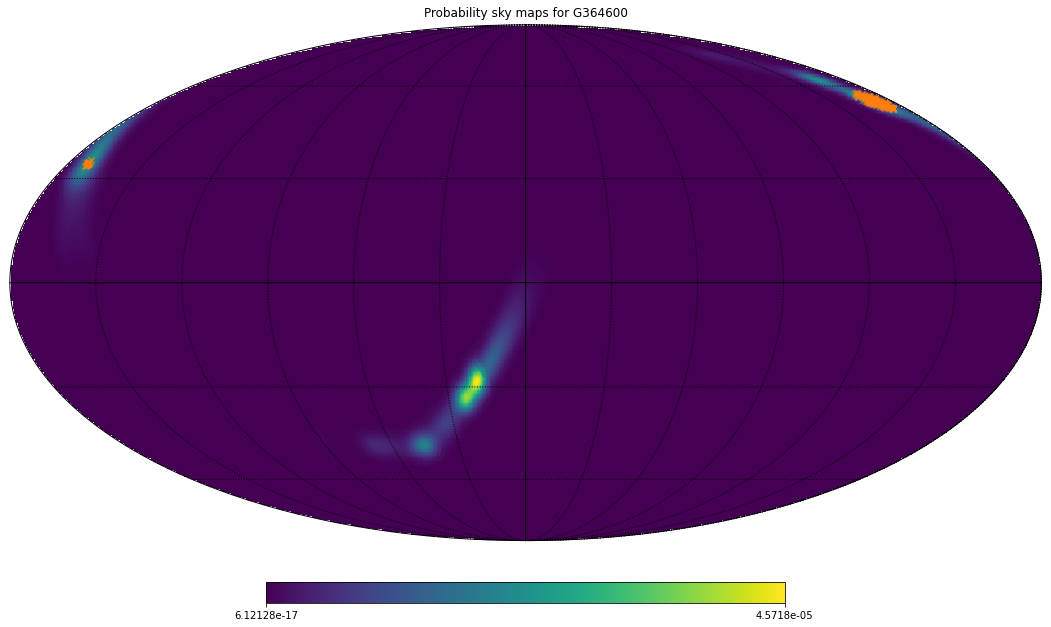

In [37]:
import healpy as hp
import matplotlib.pyplot as plt

hpx, header_ = hp.read_map(fn, h=True, field=0)
header = {i[0]: i[1] for i in header_}

fig = plt.figure(0, figsize=(15, 12))

title = 'Probability sky maps for {}'.format(header['OBJECT'])
hp.mollview(hpx, title=title, fig=0)

if len(pdf) > 0:
    hp.projscatter(
        pdf['i:ra'],
        pdf['i:dec'],
        lonlat=True,
        marker='x',
        color='C1',
        alpha=0.5
    )

hp.graticule()
plt.show()

84.72929486754718 95.27070513245282 -5.270705132452812 5.270705132452812
84.72929486754718 95.27070513245282 -5.270705132452812 5.270705132452812
/Users/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


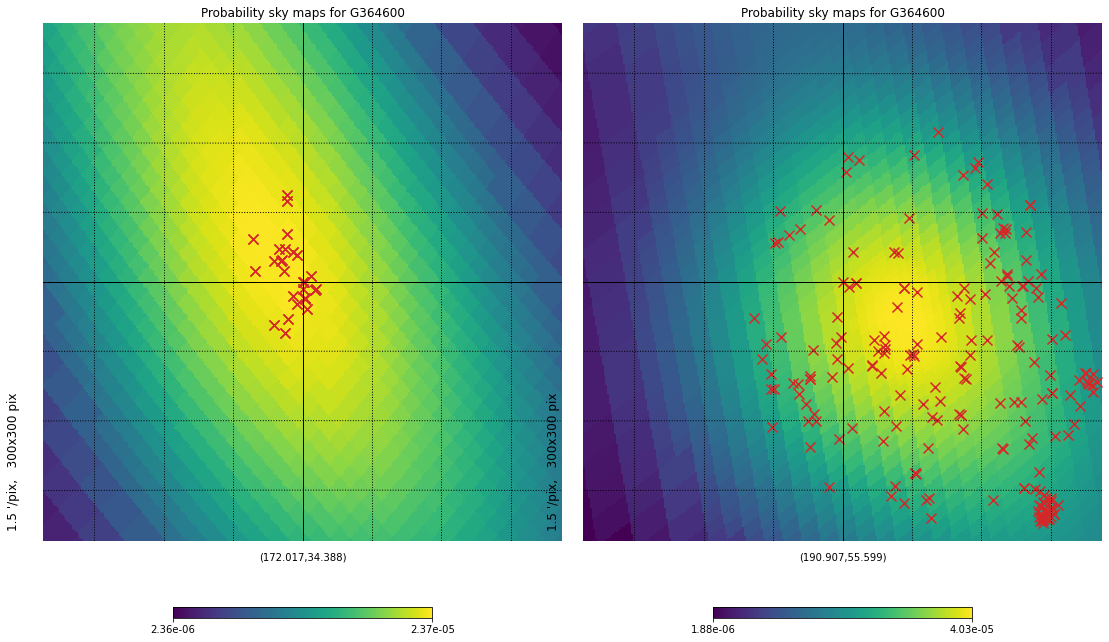

In [64]:
import healpy as hp
import matplotlib.pyplot as plt

hpx, header_ = hp.read_map(fn, h=True, field=0)
header = {i[0]: i[1] for i in header_}

fig = plt.figure(figsize=(15, 12))

title = 'Probability sky maps for {}'.format(header['OBJECT'])
hp.gnomview(
    hpx, 
    title=title, 
    fig=0, 
    rot=(pdf['i:ra'].values[-1], pdf['i:dec'].values[-1]),
    xsize=300,
    sub=(1,2, 1)
)

if len(pdf) > 0:
    hp.projscatter(
        pdf['i:ra'],
        pdf['i:dec'],
        lonlat=True,
        marker='x',
        color='C3',
        s=100
    )
    
title = 'Probability sky maps for {}'.format(header['OBJECT'])
hp.gnomview(
    hpx, 
    title=title, 
    fig=0, 
    rot=(pdf['i:ra'].values[0], pdf['i:dec'].values[0]),
    xsize=300,
    sub=(1,2, 2)
)

if len(pdf) > 0:
    hp.projscatter(
        pdf['i:ra'],
        pdf['i:dec'],
        lonlat=True,
        marker='x',
        color='C3',
        s=100,
    )

hp.graticule()
plt.tight_layout()
plt.show()